In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-questions-pair/sample_submission.csv
/kaggle/input/quora-questions-pair/train.csv
/kaggle/input/quora-questions-pair/test.csv


In [6]:
import pandas as pd
import numpy as np


import nltk
import re
import string
from wordcloud import WordCloud

import tensorflow as tf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score


In [1]:
import kagglehub
import pandas as pd

# Change the path based on your Google Drive location
train_path = '/kaggle/input/quora-questions-pair/train.csv'
test_path = '/kaggle/input/quora-questions-pair/test.csv'
submission_path = '/kaggle/input/quora-questions-pair/sample_submission.csv'

# Load the 
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_submission = pd.read_csv(submission_path)


<ipython-input-1-3cf2da94040d>:11: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(test_path)


In [2]:
print(train_df.head())

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  


In [4]:
print(test_df.head())

  test_id                                          question1  \
0       0  How does the Surface Pro himself 4 compare wit...   
1       1  Should I have a hair transplant at age 24? How...   
2       2  What but is the best way to send money from Ch...   
3       3                        Which food not emulsifiers?   
4       4                   How "aberystwyth" start reading?   

                                           question2  
0  Why did Microsoft choose core m3 and not core ...  
1        How much cost does hair transplant require?  
2                      What you send money to China?  
3                                  What foods fibre?  
4                     How their can I start reading?  


**: Exploratory Data Analysis (EDA)**

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


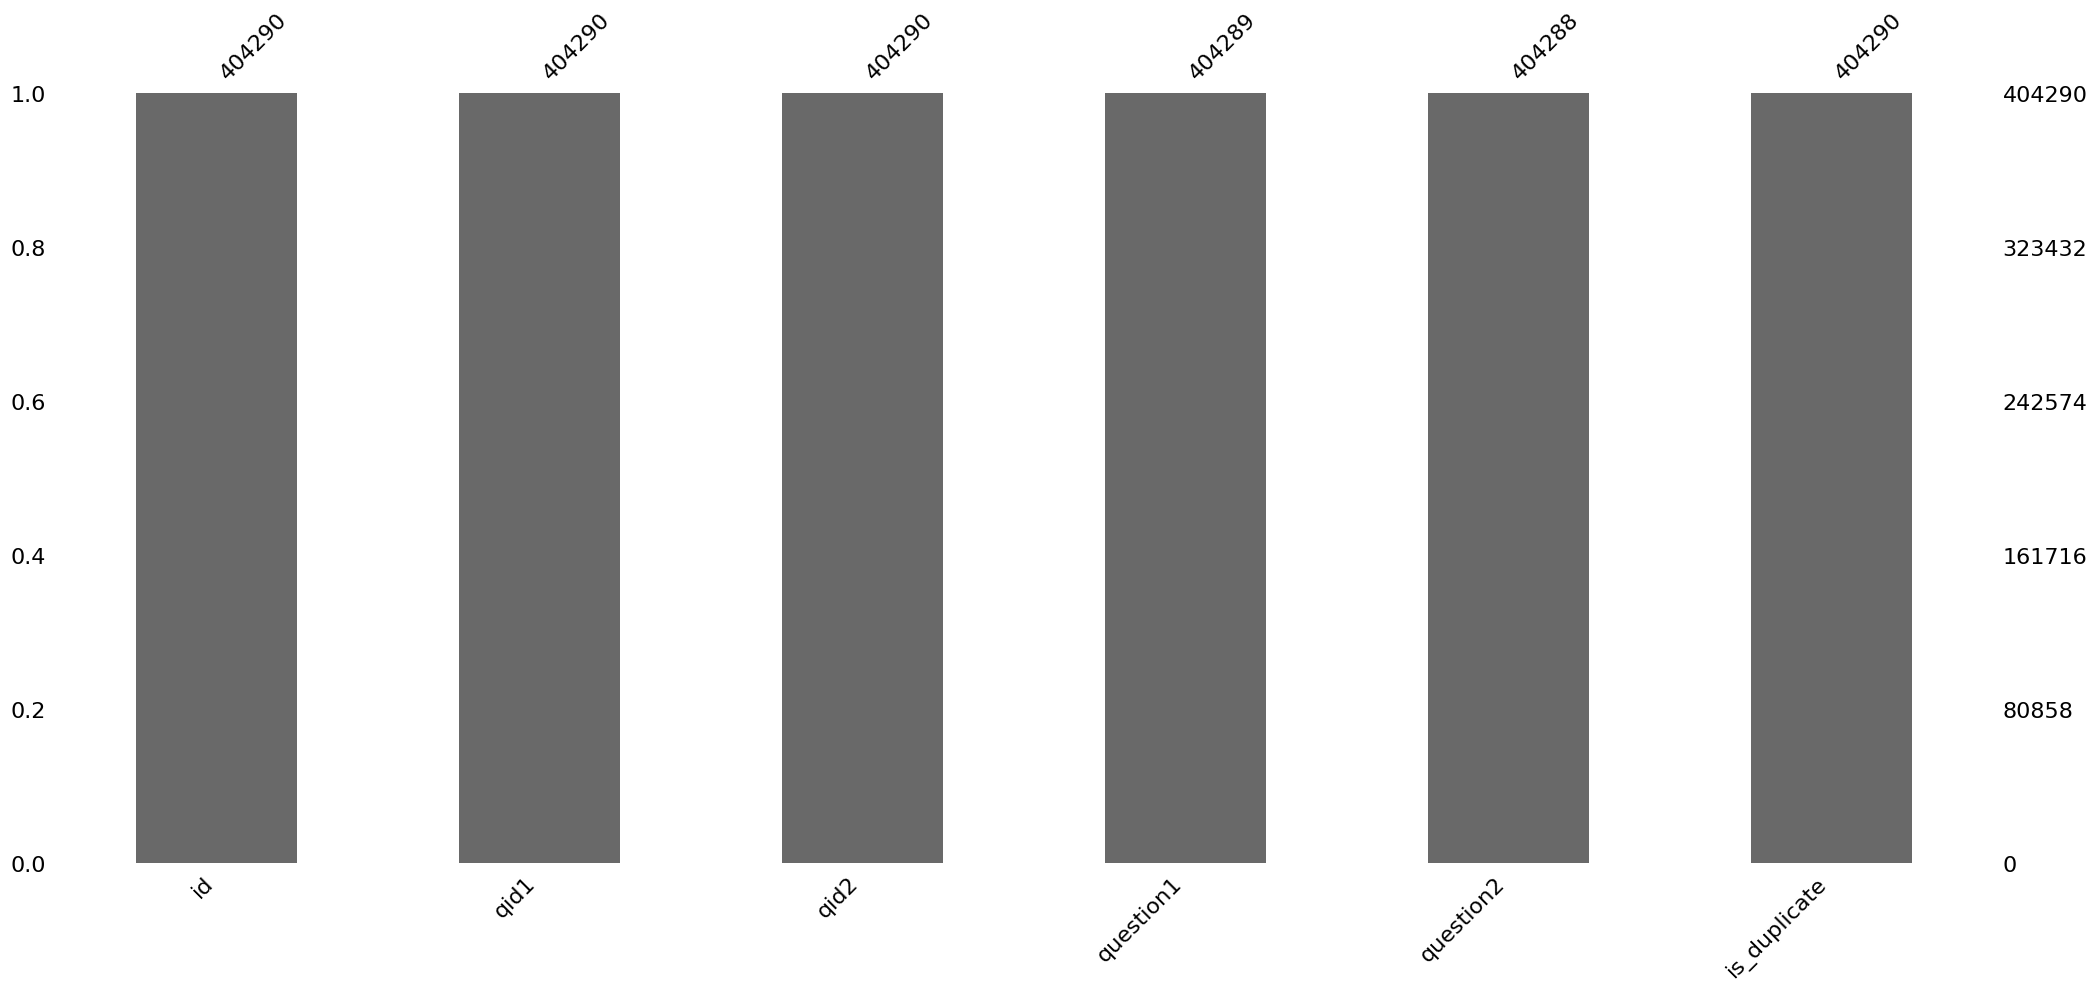

In [7]:
import missingno as msno
print(train_df.isnull().sum())
# Visualize missing data
msno.bar(train_df)
plt.show()


In [27]:
train_df.dropna(inplace=True)
print(train_df.isnull().sum())


id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


In [26]:
train_df.loc[:, "question1"] = train_df["question1"].fillna("missing_question")
train_df.loc[:, "question2"] = train_df["question2"].fillna("missing_question")

# Check Missing Values Again
print(train_df.isnull().sum())


id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64


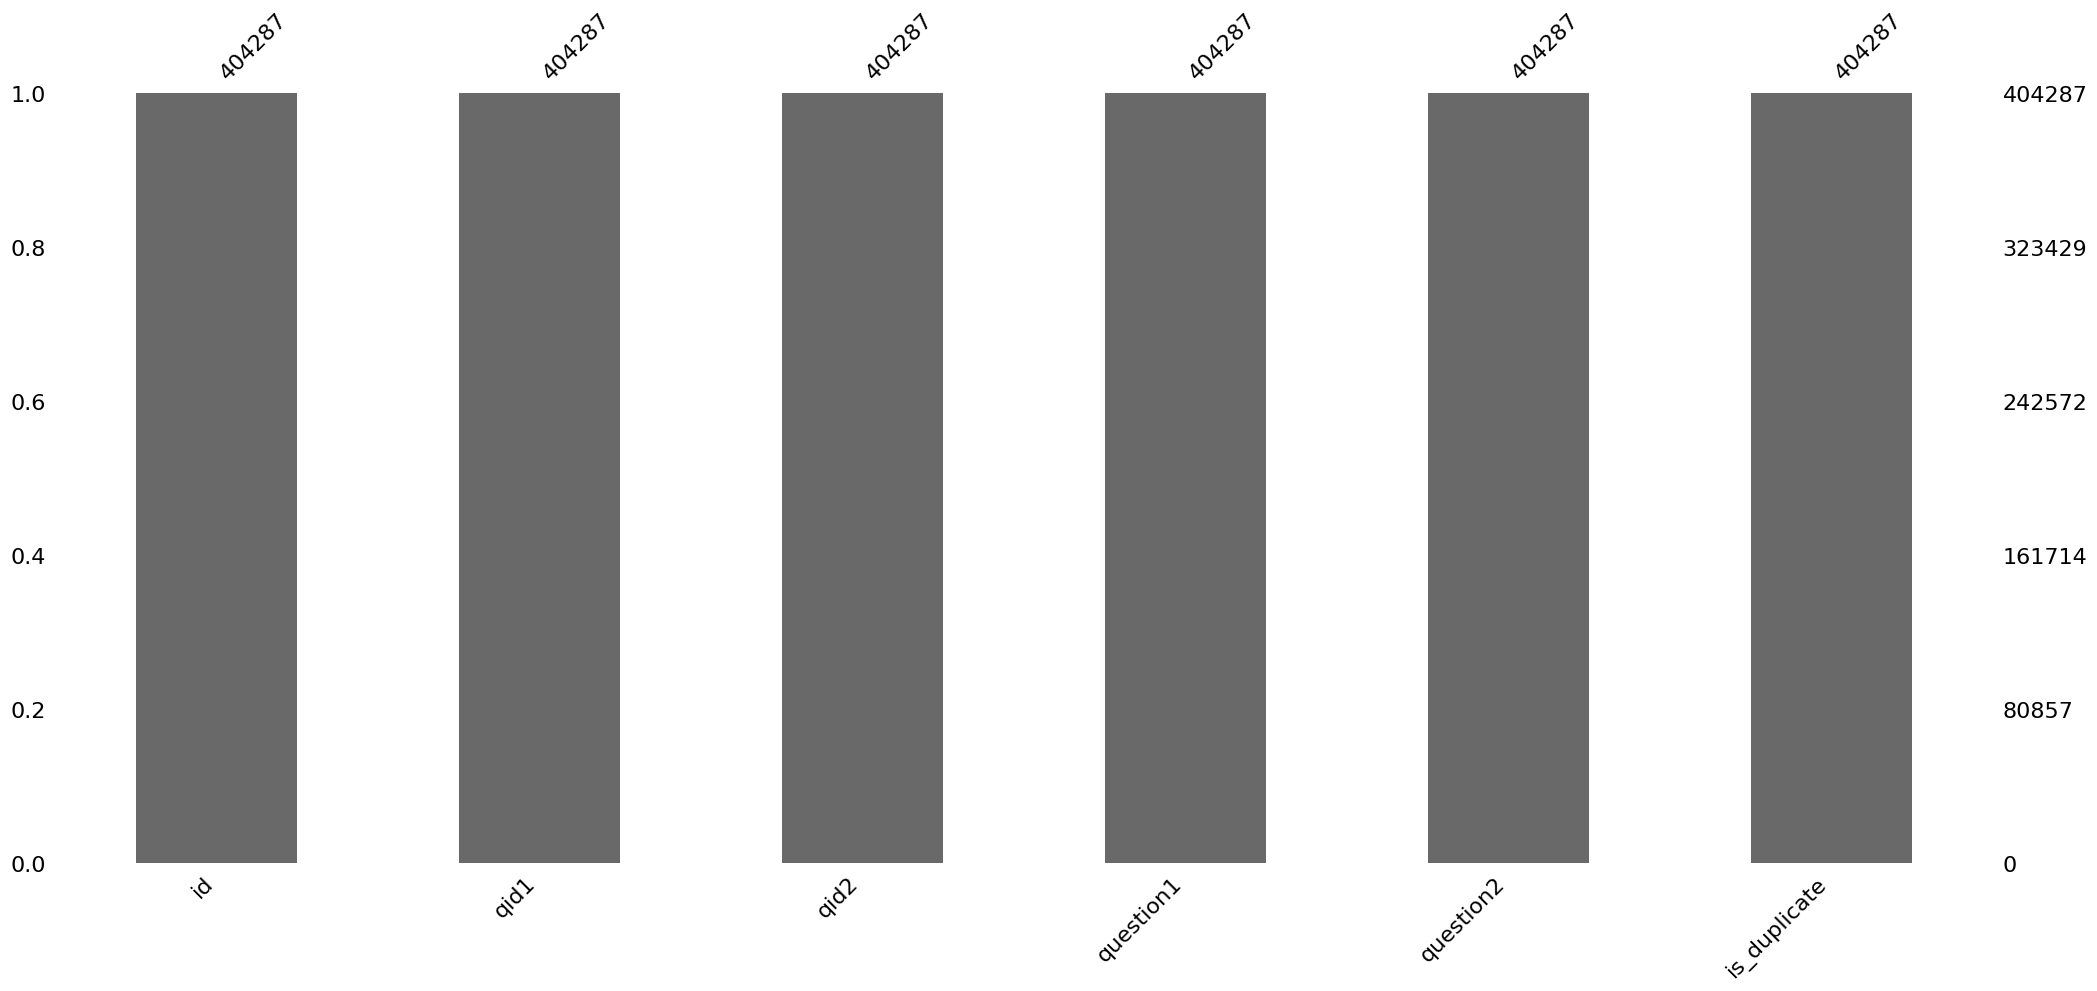

In [29]:
import missingno as msno

msno.bar(train_df)
plt.show()


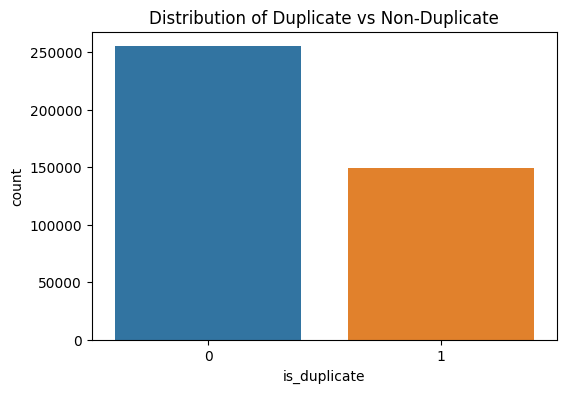

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.countplot(x=train_df["is_duplicate"])
plt.title("Distribution of Duplicate vs Non-Duplicate")
plt.show()


Visualizing Target Variable Distribution (is_duplicate)

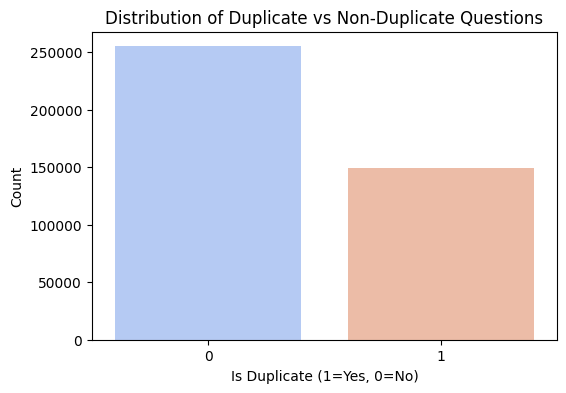

Percentage of Duplicate Questions: 36.92%


In [30]:
# Plot distribution of 'is_duplicate' column
plt.figure(figsize=(6,4))
sns.countplot(x='is_duplicate', data=train_df, palette='coolwarm')
plt.title("Distribution of Duplicate vs Non-Duplicate Questions")
plt.xlabel("Is Duplicate (1=Yes, 0=No)")
plt.ylabel("Count")
plt.show()

# Percentage of duplicates
duplicate_percentage = train_df["is_duplicate"].mean() * 100
print(f"Percentage of Duplicate Questions: {duplicate_percentage:.2f}%")


Question Length Analysis

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


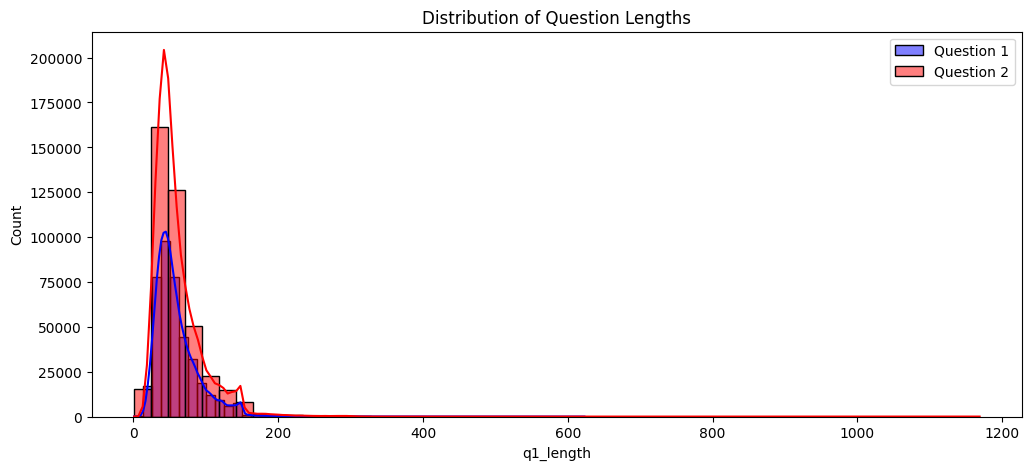

In [32]:
# Compute text length features
train_df['q1_length'] = train_df['question1'].astype(str).apply(len)
train_df['q2_length'] = train_df['question2'].astype(str).apply(len)

# Plot distribution of question lengths
plt.figure(figsize=(12,5))
sns.histplot(train_df['q1_length'], bins=50, label="Question 1", kde=True, color='blue')
sns.histplot(train_df['q2_length'], bins=50, label="Question 2", kde=True, color='red')
plt.title("Distribution of Question Lengths")
plt.legend()
plt.show()


Number of Words in Questions

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


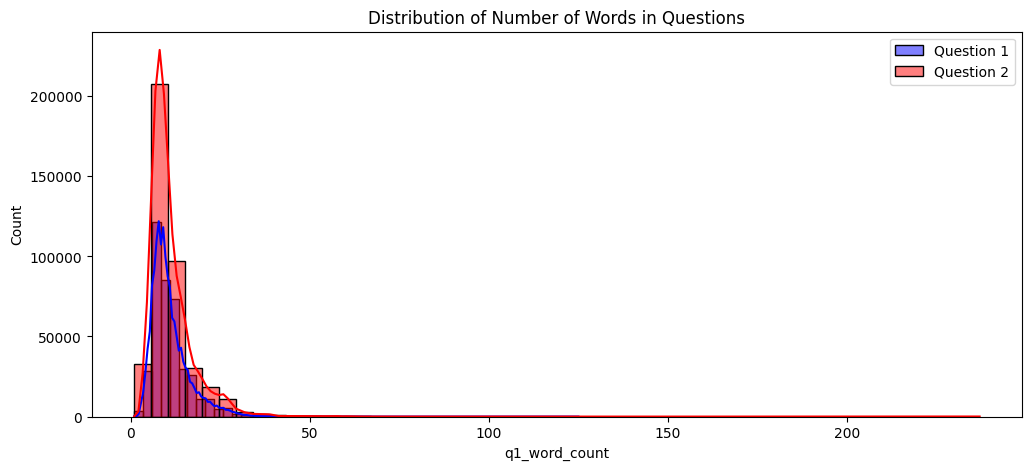

In [33]:
train_df['q1_word_count'] = train_df['question1'].astype(str).apply(lambda x: len(x.split()))
train_df['q2_word_count'] = train_df['question2'].astype(str).apply(lambda x: len(x.split()))

# Plot
plt.figure(figsize=(12,5))
sns.histplot(train_df['q1_word_count'], bins=50, label="Question 1", kde=True, color='blue')
sns.histplot(train_df['q2_word_count'], bins=50, label="Question 2", kde=True, color='red')
plt.title("Distribution of Number of Words in Questions")
plt.legend()
plt.show()


Word Cloud for Duplicate Questions

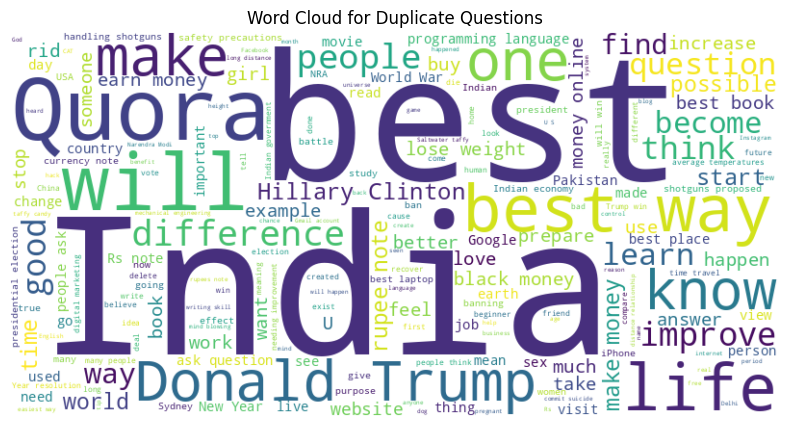

In [34]:
from wordcloud import WordCloud, STOPWORDS

# Combine all duplicate questions
duplicate_questions = " ".join(train_df[train_df["is_duplicate"] == 1]["question1"].astype(str) + 
                               " " + train_df[train_df["is_duplicate"] == 1]["question2"].astype(str))

# Generate word cloud
plt.figure(figsize=(10,5))
wc = WordCloud(stopwords=STOPWORDS, background_color="white", width=800, height=400).generate(duplicate_questions)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Duplicate Questions")
plt.show()


Word Cloud for Non-Duplicate Questions

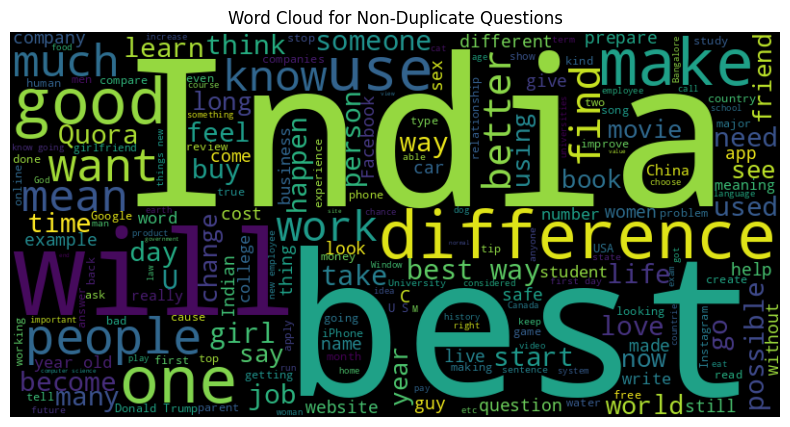

In [35]:
# Combine all non-duplicate questions
non_duplicate_questions = " ".join(train_df[train_df["is_duplicate"] == 0]["question1"].astype(str) + 
                                   " " + train_df[train_df["is_duplicate"] == 0]["question2"].astype(str))

# Generate word cloud
plt.figure(figsize=(10,5))
wc = WordCloud(stopwords=STOPWORDS, background_color="black", width=800, height=400).generate(non_duplicate_questions)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud for Non-Duplicate Questions")
plt.show()


Character Length vs. Duplicate Rate

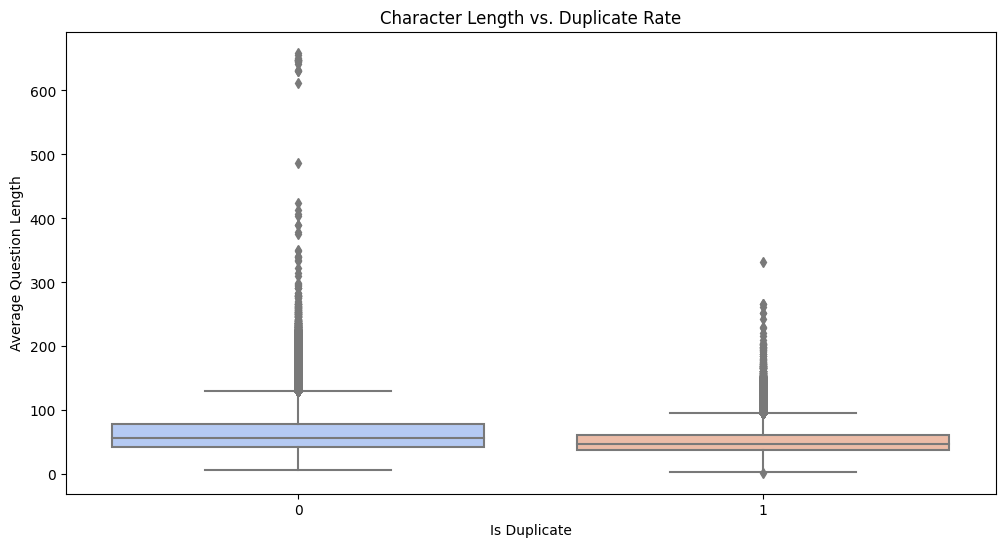

In [36]:
# Compute average character length of both questions
train_df["avg_length"] = (train_df["q1_length"] + train_df["q2_length"]) / 2

# Plot duplicate rate vs. average question length
plt.figure(figsize=(12,6))
sns.boxplot(x=train_df["is_duplicate"], y=train_df["avg_length"], palette="coolwarm")
plt.title("Character Length vs. Duplicate Rate")
plt.xlabel("Is Duplicate")
plt.ylabel("Average Question Length")
plt.show()


Correlation Analysis

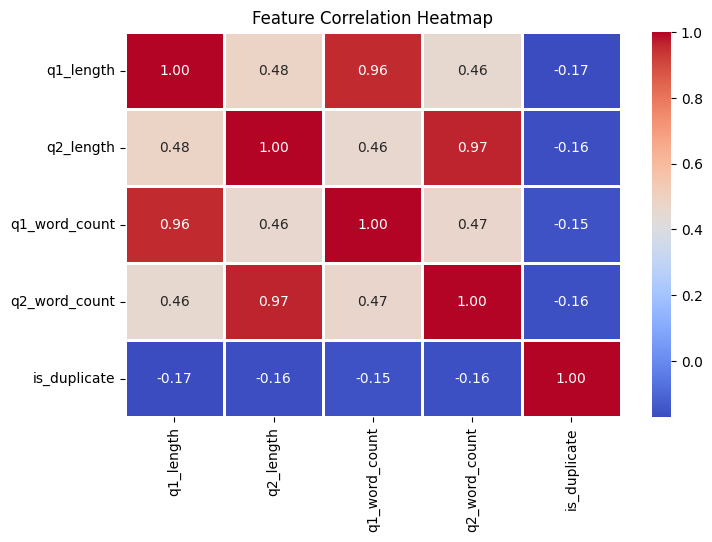

In [37]:
# Select relevant numerical columns
corr_features = train_df[['q1_length', 'q2_length', 'q1_word_count', 'q2_word_count', 'is_duplicate']]

# Compute correlation matrix
plt.figure(figsize=(8,5))
sns.heatmap(corr_features.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=1)
plt.title("Feature Correlation Heatmap")
plt.show()


**Text Preprocessing**

Text Cleaning Function

In [18]:
import re
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

r
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download necessary resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset
train_df = pd.read_csv(train_path)

def clean_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters, punctuation, and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenization
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Join words back to text
    return " ".join(words)

# Apply cleaning function to both question columns
train_df["question1"] = train_df["question1"].astype(str).apply(clean_text)
train_df["question2"] = train_df["question2"].astype(str).apply(clean_text)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [38]:
# Check processed text
print(train_df[["question1", "question2"]].head())


                                           question1  \
0  What is the step by step guide to invest in sh...   
1  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2  How can I increase the speed of my internet co...   
3  Why am I mentally very lonely? How can I solve...   
4  Which one dissolve in water quikly sugar, salt...   

                                           question2  
0  What is the step by step guide to invest in sh...  
1  What would happen if the Indian government sto...  
2  How can Internet speed be increased by hacking...  
3  Find the remainder when [math]23^{24}[/math] i...  
4            Which fish would survive in salt water?  


In [39]:
print(train_df[["question1", "question2"]].sample(5))  # Randomly sample 5 rows



                                                question1  \
277961  What is the best sex experience you have ever ...   
26906   What are some common examples of renewable res...   
282275  What are some of the best work-from-home jobs ...   
113482      What is the scope of BDS in India and abroad?   
354098  How can I increase traffic on buymarijuanaonli...   

                                                question2  
277961                    What was best sex you ever had?  
26906     What are renewable and non-renewable resources?  
282275  What are some of the best work from home jobs ...  
113482                 What is the scope of BDS in India?  
354098          How can I increase the traffic on a site?  


TF-IDF Vectorization

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Limiting vocabulary to 5000 words

# Fit and transform questions
questions_combined = train_df["question1"] + " " + train_df["question2"]
X_tfidf = tfidf.fit_transform(questions_combined)

# Convert to array
X_tfidf = X_tfidf.toarray()

# Print shape of transformed data
print("TF-IDF Matrix Shape:", X_tfidf.shape)


TF-IDF Matrix Shape: (404287, 5000)


Word Embeddings (Word2Vec/GloVe)

In [42]:
import gensim
from gensim.models import Word2Vec

# Tokenize sentences into words
train_df["question1_tokenized"] = train_df["question1"].apply(lambda x: x.split())
train_df["question2_tokenized"] = train_df["question2"].apply(lambda x: x.split())

# Combine all tokenized words
all_words = train_df["question1_tokenized"].tolist() + train_df["question2_tokenized"].tolist()

# Train Word2Vec model
w2v_model = Word2Vec(sentences=all_words, vector_size=100, window=5, min_count=1, workers=4)

# Check embedding of a sample word
print("Example Word Embedding for 'question':", w2v_model.wv["question"])


Example Word Embedding for 'question': [ 0.5674638  -1.9519241   2.465022    2.7528965  -0.9610706   0.22382578
  0.30985773  1.7493597   0.07785735 -1.8378216  -3.3726096  -1.3897728
  2.29561     0.25380826 -1.2500362  -1.1138033   5.5992427   0.17003824
 -3.2904432  -0.161759    1.795739   -0.934319   -0.17436218 -2.2524018
 -1.5292119   2.6482947   3.6443768  -0.16766927  0.2733323   3.9856021
 -0.2380151  -1.1047237  -2.097807    0.28854582  1.0713798   1.1480783
  1.2432383  -1.3210394   1.0676565   0.30634737  0.37841547  2.4228656
  0.20092708  2.1184976   0.88711786 -1.1646838   1.623853    0.09564149
 -0.87326694  0.5185292  -1.7541353   3.4728782  -2.0785086  -3.2683551
  3.944554    0.59299177 -1.3662034   1.719277    6.185639    2.033468
 -0.08454966  5.354751    0.11793998 -0.45495954 -0.8198527  -2.4950936
  2.2612536   1.2251062  -4.4991474   1.8107145   3.0448613  -1.3114923
  2.7659576   2.052108   -2.14509    -0.48853505  1.648195   -0.6916598
 -3.788031    1.8810863

Tokenization & Padding for Deep Learning

In [47]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Use Keras Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")

# Fit tokenizer on combined questions
tokenizer.fit_on_texts(questions_combined)

# Convert text to sequences
X_sequences_q1 = tokenizer.texts_to_sequences(train_df["question1"])
X_sequences_q2 = tokenizer.texts_to_sequences(train_df["question2"])

# Pad sequences to make them equal length
max_length = 30  # Adjust based on data
X_padded_q1 = pad_sequences(X_sequences_q1, maxlen=max_length, padding="post")
X_padded_q2 = pad_sequences(X_sequences_q2, maxlen=max_length, padding="post")

# Stack both question representations
X_padded = np.hstack((X_padded_q1, X_padded_q2))

# Print shape
print("Padded Sequences Shape:", X_padded.shape)


Padded Sequences Shape: (404287, 60)


**Artificial Neural Network (ANN) & model evaluation****

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

y = train_df["is_duplicate"].values  # Labels (0 or 1)

# Split into train and validation sets
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(
    X1, X2, y, test_size=0.2, random_state=42
)


# Tokenizing questions
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["question1"].tolist() + train_df["question2"].tolist())

# Convert text to sequences
X1 = tokenizer.texts_to_sequences(train_df["question1"])
X2 = tokenizer.texts_to_sequences(train_df["question2"])

# Pad sequences
X1 = pad_sequences(X1, maxlen=max_len, padding="post", truncating="post")
X2 = pad_sequences(X2, maxlen=max_len, padding="post", truncating="post")

# Define input layers
max_len = 50  
input_q1 = Input(shape=(max_len,))
input_q2 = Input(shape=(max_len,))

# Embedding layer
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for padding
embedding_dim = 128
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)

# Process both question inputs
embedding_q1 = embedding_layer(input_q1)
embedding_q2 = embedding_layer(input_q2)

# Flatten layers
flat_q1 = Flatten()(embedding_q1)
flat_q2 = Flatten()(embedding_q2)

# Concatenate
merged = Concatenate()([flat_q1, flat_q2])

# Fully connected layers
dense1 = Dense(256, activation="relu")(merged)
dense2 = Dense(128, activation="relu")(dense1)
output = Dense(1, activation="sigmoid")(dense2)

# Define model
model = Model(inputs=[input_q1, input_q2], outputs=output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train model
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1, X2, y, test_size=0.2, random_state=42)
model.fit([X1_train, X2_train], y_train, validation_data=([X1_val, X2_val], y_val), epochs=5, batch_size=64)

# Evaluate model
model.evaluate([X1_val, X2_val], y_val)


Epoch 1/5
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.7386 - loss: 0.5212 - val_accuracy: 0.7803 - val_loss: 0.4547
Epoch 2/5
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.8096 - loss: 0.4022 - val_accuracy: 0.7894 - val_loss: 0.4490
Epoch 3/5
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.8458 - loss: 0.3338 - val_accuracy: 0.7904 - val_loss: 0.4644
Epoch 4/5
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.8779 - loss: 0.2721 - val_accuracy: 0.7868 - val_loss: 0.4946
Epoch 5/5
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9013 - loss: 0.2238 - val_accuracy: 0.7936 - val_loss: 0.5760
2527/2527 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7934 - loss: 0.5706


[0.5759977102279663, 0.7935887575149536]

12635/12635 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
12635/12635 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step
ANN Model - Accuracy: 0.9004
ANN Model - Precision: 0.8619
ANN Model - Recall: 0.8697
ANN Model - F1-Score: 0.8658
ANN Model - AUC-ROC: 0.9595


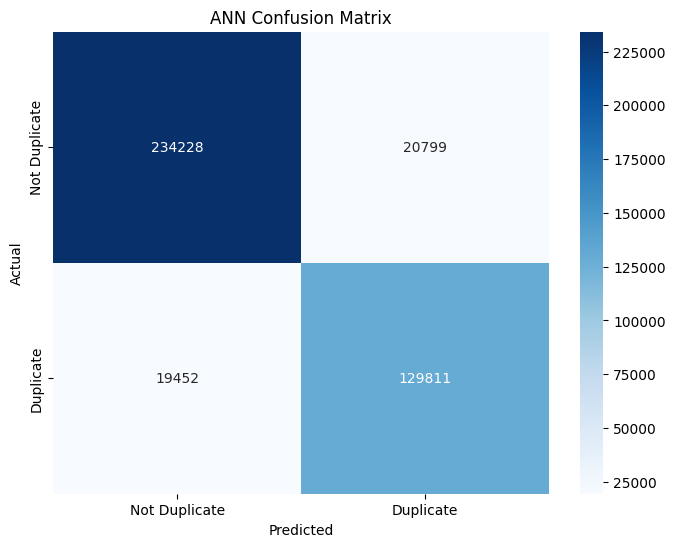

12635/12635 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step


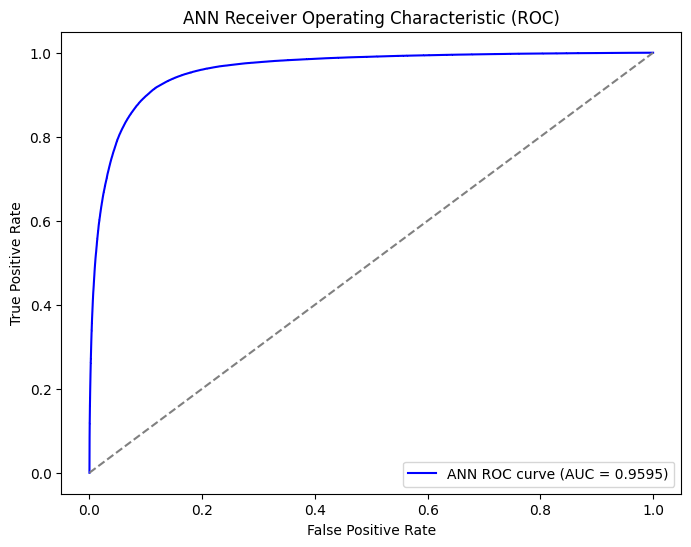

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Get predictions for ANN model
y_pred_ann = (model.predict([X1, X2]) > 0.5).astype(int)

# Calculate evaluation metrics
accuracy_ann = accuracy_score(y, y_pred_ann)
precision_ann = precision_score(y, y_pred_ann)
recall_ann = recall_score(y, y_pred_ann)
f1_ann = f1_score(y, y_pred_ann)
roc_auc_ann = roc_auc_score(y, model.predict([X1, X2]))

# Print metrics for ANN
print(f"ANN Model - Accuracy: {accuracy_ann:.4f}")
print(f"ANN Model - Precision: {precision_ann:.4f}")
print(f"ANN Model - Recall: {recall_ann:.4f}")
print(f"ANN Model - F1-Score: {f1_ann:.4f}")
print(f"ANN Model - AUC-ROC: {roc_auc_ann:.4f}")

# Confusion Matrix for ANN
cm_ann = confusion_matrix(y, y_pred_ann)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Duplicate', 'Duplicate'], 
            yticklabels=['Not Duplicate', 'Duplicate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ANN Confusion Matrix')
plt.show()

# AUC-ROC for ANN
from sklearn.metrics import roc_curve

fpr_ann, tpr_ann, _ = roc_curve(y, model.predict([X1, X2]))
plt.figure(figsize=(8, 6))
plt.plot(fpr_ann, tpr_ann, color='b', label='ANN ROC curve (AUC = %0.4f)' % roc_auc_ann)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANN Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


**LSTM/GRU Model & evaluation**

In [13]:
import pandas as pd
train_path = '/kaggle/input/quora-questions-pair/train.csv'
test_path = '/kaggle/input/quora-questions-pair/test.csv'
submission_path = '/kaggle/input/quora-questions-pair/sample_submission.csv'

# Load the 
train_df = pd.read_csv(train_path)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_q1 (InputLayer)     │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_q2 (InputLayer)     │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 128)        │     12,236,544 │ input_q1[0][0],        │
│                           │                        │                │ input_q2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 256)            │        263,168 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 256)            │        263,168 │ embedding[1][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512)            │              0 │ bidirectional[0][0],   │
│                           │                        │                │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        131,328 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │            129 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 12,927,233 (49.31 MB)

 Trainable params: 12,927,233 (49.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 117s 22ms/step - accuracy: 0.7389 - loss: 0.5260 - val_accuracy: 0.7747 - val_loss: 0.4603
Epoch 2/10
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - accuracy: 0.7887 - loss: 0.4392 - val_accuracy: 0.7892 - val_loss: 0.4380
Epoch 3/10
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - accuracy: 0.8162 - loss: 0.3943 - val_accuracy: 0.8004 - val_loss: 0.4281
Epoch 4/10
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - accuracy: 0.8371 - loss: 0.3560 - val_accuracy: 0.8054 - val_loss: 0.4185
Epoch 5/10
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - accuracy: 0.8573 - loss: 0.3220 - val_accuracy: 0.8091 - val_loss: 0.4213
Epoch 6/10
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - accuracy: 0.8740 - loss: 0.2884 - val_accuracy: 0.8074 - val_loss: 0.4355
Epoch 7/10
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - accuracy: 0.8887 - loss: 0.2579 - val_accuracy: 0.8098 - val_loss: 0.4581
Epoch 8/10
5054/5054 ━━━━━━━━━━━━━━━━━━━━ 110s 22ms/step - accuracy: 

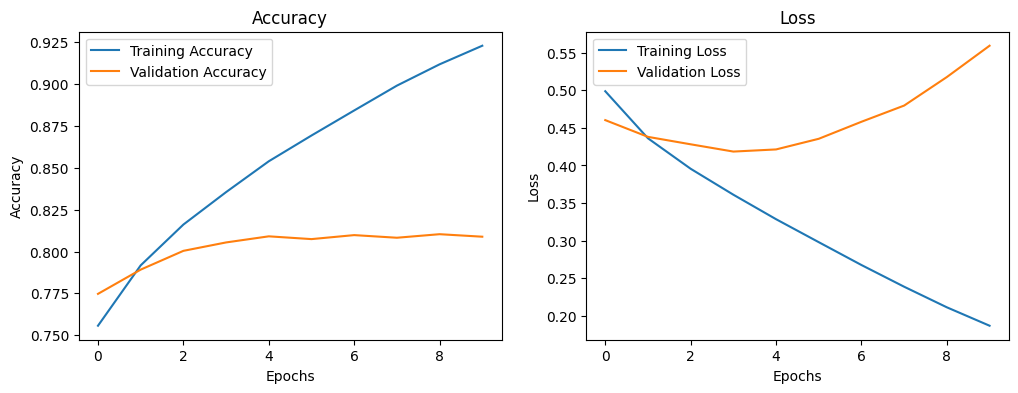

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Concatenate, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
train_df = pd.read_csv(train_path)

# Labels (0 or 1)
y = train_df["is_duplicate"].values

# Tokenizing questions
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["question1"].astype(str).tolist() + train_df["question2"].astype(str).tolist())

# Convert text to sequences
X1 = tokenizer.texts_to_sequences(train_df["question1"].astype(str))
X2 = tokenizer.texts_to_sequences(train_df["question2"].astype(str))

# Pad sequences
max_len = 50  # Max length of sequences
X1 = pad_sequences(X1, maxlen=max_len, padding="post", truncating="post")
X2 = pad_sequences(X2, maxlen=max_len, padding="post", truncating="post")

# Split into train and validation sets
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(
    X1, X2, y, test_size=0.2, random_state=42
)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128

# Define input layers
input_q1 = Input(shape=(max_len,), name="input_q1")
input_q2 = Input(shape=(max_len,), name="input_q2")

# Embedding layer
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)

# Process both questions with LSTM
lstm_units = 128

embedding_q1 = embedding_layer(input_q1)
embedding_q2 = embedding_layer(input_q2)

lstm_q1 = Bidirectional(LSTM(lstm_units, return_sequences=False))(embedding_q1)
lstm_q2 = Bidirectional(LSTM(lstm_units, return_sequences=False))(embedding_q2)

# Concatenate both outputs
merged = Concatenate()([lstm_q1, lstm_q2])

# Fully connected layers
dense1 = Dense(256, activation="relu")(merged)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation="relu")(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation="sigmoid")(dropout2)

# Define model
model = Model(inputs=[input_q1, input_q2], outputs=output)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Summary of model
model.summary()

# Train model
epochs = 10
batch_size = 64
history = model.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_val, X2_val], y_val),
    epochs=epochs, batch_size=batch_size,
    verbose=1
)

# Evaluate model
loss, accuracy = model.evaluate([X1_val, X2_val], y_val)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


12635/12635 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step
12635/12635 ━━━━━━━━━━━━━━━━━━━━ 57s 5ms/step
LSTM Model - Accuracy: 0.9216
LSTM Model - Precision: 0.8814
LSTM Model - Recall: 0.9100
LSTM Model - F1-Score: 0.8955
LSTM Model - AUC-ROC: 0.9697


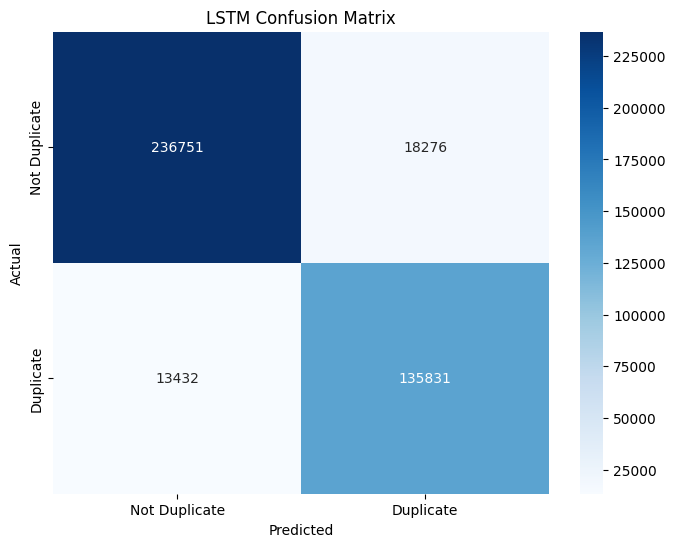

12635/12635 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step


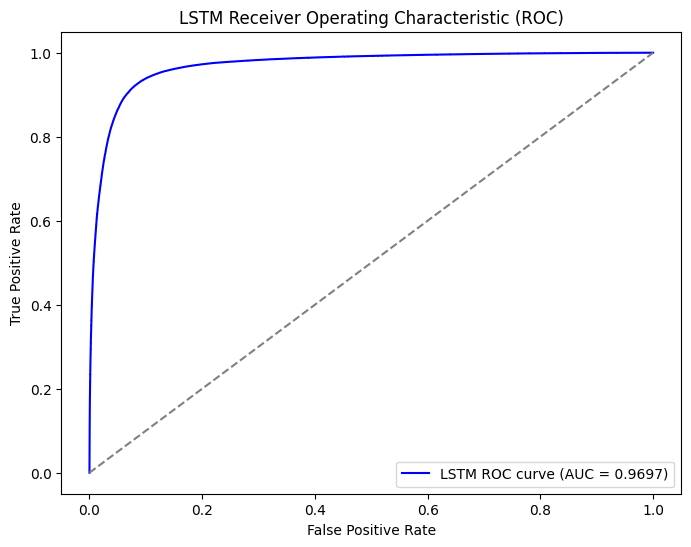

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred = (model.predict([X1, X2]) > 0.5).astype(int)

# Calculate evaluation metrics
accuracy_lstm = accuracy_score(y, y_pred)
precision_lstm = precision_score(y, y_pred)
recall_lstm = recall_score(y, y_pred)
f1_lstm = f1_score(y, y_pred)
roc_auc_lstm = roc_auc_score(y, model.predict([X1, X2]))

print(f"LSTM Model - Accuracy: {accuracy_lstm:.4f}")
print(f"LSTM Model - Precision: {precision_lstm:.4f}")
print(f"LSTM Model - Recall: {recall_lstm:.4f}")
print(f"LSTM Model - F1-Score: {f1_lstm:.4f}")
print(f"LSTM Model - AUC-ROC: {roc_auc_lstm:.4f}")

# Confusion Matrix
cm_lstm = confusion_matrix(y, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Duplicate', 'Duplicate'], 
            yticklabels=['Not Duplicate', 'Duplicate'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM Confusion Matrix')
plt.show()

# ROC Curve
fpr_lstm, tpr_lstm, _ = roc_curve(y, model.predict([X1, X2]))
plt.figure(figsize=(8, 6))
plt.plot(fpr_lstm, tpr_lstm, color='b', label='LSTM ROC curve (AUC = %0.4f)' % roc_auc_lstm)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

SVM Baseline & Logistic Regression Baseline LSTM

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
# Logistic Regression Baseline
lr_model = LogisticRegression()
lr_model.fit(X1, y)
y_pred_lr = lr_model.predict(X1)
print(f"Logistic Regression Accuracy: {accuracy_score(y, y_pred_lr):.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.6308


**Hyperparameter Optimization LSTM**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Bidirectional, Concatenate, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
train_df = pd.read_csv(train_path)

# Labels (0 or 1)
y = train_df["is_duplicate"].values

# Tokenizing questions
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["question1"].astype(str).tolist() + train_df["question2"].astype(str).tolist())

# Convert text to sequences
X1 = tokenizer.texts_to_sequences(train_df["question1"].astype(str))
X2 = tokenizer.texts_to_sequences(train_df["question2"].astype(str))

# Pad sequences
max_len = 50
X1 = pad_sequences(X1, maxlen=max_len, padding="post", truncating="post")
X2 = pad_sequences(X2, maxlen=max_len, padding="post", truncating="post")

# Split into train and validation sets
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(X1, X2, y, test_size=0.2, random_state=42)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 128
lstm_units = 128

# Hyperparameter Optimization
param_grid = {
    'optimizer': ['adam', 'sgd'],
    'batch_size': [32, 64],
    'epochs': [5, 10]
}

best_accuracy = 0
best_params = {}

for optimizer in param_grid['optimizer']:
    for batch_size in param_grid['batch_size']:
        for epochs in param_grid['epochs']:
            # Define input layers
            input_q1 = Input(shape=(max_len,), name="input_q1")
            input_q2 = Input(shape=(max_len,), name="input_q2")

            # Embedding layer
            embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len)
            
            embedding_q1 = embedding_layer(input_q1)
            embedding_q2 = embedding_layer(input_q2)

            # LSTM Layers
            lstm_q1 = Bidirectional(LSTM(lstm_units, return_sequences=False))(embedding_q1)
            lstm_q2 = Bidirectional(LSTM(lstm_units, return_sequences=False))(embedding_q2)

            # Concatenate both outputs
            merged = Concatenate()([lstm_q1, lstm_q2])

            # Fully connected layers
            dense1 = Dense(256, activation="relu")(merged)
            dropout1 = Dropout(0.5)(dense1)
            dense2 = Dense(128, activation="relu")(dropout1)
            dropout2 = Dropout(0.5)(dense2)
            output = Dense(1, activation="sigmoid")(dropout2)

            # Define model
            model = Model(inputs=[input_q1, input_q2], outputs=output)
            model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

            # Train model
            history = model.fit([X1_train, X2_train], y_train, validation_data=([X1_val, X2_val], y_val),
                                epochs=epochs, batch_size=batch_size, verbose=0)

            val_accuracy = model.evaluate([X1_val, X2_val], y_val, verbose=0)[1]

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'optimizer': optimizer, 'batch_size': batch_size, 'epochs': epochs}

print(f"Best Accuracy: {best_accuracy:.4f} with Params: {best_params}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
